In [1]:
#Imports
import gym
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers


#Environment
env = gym.make("CartPole-v0")
#env = gym.wrappers.Monitor(env, directory="mon", force=True)
obs_size = env.observation_space.shape
n_actions = env.action_space.n

#Simple NN model
model = Sequential()
hidden = 128

model.add(Dense(hidden, activation='relu', input_shape=(obs_size)))
model.add(Dense(n_actions, activation='softmax'))

#Initial observation
'''obs = env.reset()
print("The initial observation is: ", obs)'''
print("There are", n_actions,"actions available. (LEFT/RIGHT)")
print("The model has a single hidden layer of size:", hidden)

c:\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 2 actions available. (LEFT/RIGHT)
The model has a single hidden layer of size: 128


In [2]:
#Compile the model
adam = optimizers.adam(lr=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled with adam optimitzer and categorical crossentropy loss.")

Model compiled with adam optimitzer and categorical crossentropy loss.


In [3]:
#Play one episode
def play(env, render=False, monitor=False):
    episode_reward = 0.0
    episode_obs = []
    episode_actions = []
    if monitor:
        env = gym.wrappers.Monitor(env, directory='saves_' + str(time.time()) + '/')
    obs = env.reset()
    while True:
        #Take one step
        if render:
            env.render()
        actions = model.predict(obs.reshape(1,-1)).reshape(-1)
        
        #Pick a random action based on probability
        action = np.random.choice(len(actions), p=actions)
        next_obs, reward, is_done, _ = env.step(action)

        #Sum the rewards
        episode_reward += reward

        #Record the step
        episode_obs.append(obs)
        if action == 0:
            episode_actions.append([1,0])
        if action == 1:
            episode_actions.append([0,1])

        #Check if game over
        if is_done:
            env.close()
            return episode_reward, episode_obs, episode_actions 
        
        obs = next_obs

In [4]:
def play_episodes(env, n):
    episodes = {"Rewards":[], "Obs":[], "Actions":[]}
    for x in range(n):
        r, s, a = play(env)
        episodes["Rewards"].append(r)
        episodes["Obs"].append(s)
        episodes["Actions"].append(a)
        
    return episodes

In [5]:
def get_best_episode(env, n):
    t_obs = []
    t_act = []
    #Play n games
    episodes = play_episodes(env, n)
    rewards = episodes["Rewards"]
    bound = np.percentile(rewards, 75)
    i = 0
    for e in rewards:
        if e < bound:
            i+=1
            continue
        t_obs.extend(episodes["Obs"][i])
        t_act.extend(episodes["Actions"][i])
        i+=1
    r = np.mean(rewards)
    print("Average reward =",np.mean(rewards)) 
    return t_obs, t_act, r

In [6]:
def train_nn(env, model, n, history):
    x,y,r = get_best_episode(env, n)
    
    history.append(r)
    #Reshape to train
    x = np.array(x).reshape(len(x), 4)
    y = np.array(y).reshape(len(y), 2)
    model.fit(x,y, epochs=1, verbose=2, batch_size=32)
    

In [7]:
#Train the model for 30 epochs with 16 episodes each
history = []
epochs = 30
for x in range(epochs):
    #Uncomment to monitor
    '''if (x == 1) or (x == 10) or (x == 29):
        play(env, False, True)'''
    train_nn(env, model, 16, history)    

Average reward = 28.875
Epoch 1/1
 - 0s - loss: 0.6954 - acc: 0.5261
Average reward = 28.3125
Epoch 1/1
 - 0s - loss: 0.6796 - acc: 0.5990
Average reward = 38.875
Epoch 1/1
 - 0s - loss: 0.6676 - acc: 0.6194
Average reward = 33.625
Epoch 1/1
 - 0s - loss: 0.6584 - acc: 0.6194
Average reward = 57.0
Epoch 1/1
 - 0s - loss: 0.6359 - acc: 0.6408
Average reward = 62.3125
Epoch 1/1
 - 0s - loss: 0.6367 - acc: 0.6545
Average reward = 51.875
Epoch 1/1
 - 0s - loss: 0.6362 - acc: 0.6361
Average reward = 77.25
Epoch 1/1
 - 0s - loss: 0.6057 - acc: 0.6819
Average reward = 73.3125
Epoch 1/1
 - 0s - loss: 0.5849 - acc: 0.6990
Average reward = 124.25
Epoch 1/1
 - 0s - loss: 0.5881 - acc: 0.7117
Average reward = 134.4375
Epoch 1/1
 - 0s - loss: 0.5496 - acc: 0.7240
Average reward = 142.0625
Epoch 1/1
 - 0s - loss: 0.5567 - acc: 0.7180
Average reward = 116.8125
Epoch 1/1
 - 0s - loss: 0.5452 - acc: 0.7158
Average reward = 132.125
Epoch 1/1
 - 0s - loss: 0.5435 - acc: 0.7347
Average reward = 177.8125
E

Average rewards by epoch


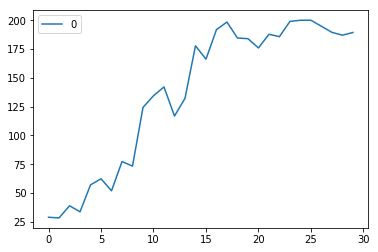

In [8]:
import pandas as pd
%matplotlib inline
pd.DataFrame(history).plot()
print("Average rewards by epoch")

## Random agent

In [9]:
from IPython.display import Video
Video("./video/random_cart.mp4", embed=True)

## 10_epochs trained agent

In [10]:
Video("./video/10_epochs_cart.mp4", embed=True)

## 30_epochs trained agent

In [11]:
Video("./video/30_epochs_cart.mp4", embed=True)